In [2]:
!pip install librosa

/usr/lib/python3/dist-packages/secretstorage/dhcrypto.py:15: CryptographyDeprecationWarning: Python 3.6 is no longer supported by the Python core team. Therefore, support for it is deprecated in cryptography. The next release of cryptography (40.0) will be the last to support Python 3.6.
  from cryptography.utils import int_from_bytes
Defaulting to user installation because normal site-packages is not writeable
  Using cached librosa-0.9.2-py3-none-any.whl (214 kB)
  Using cached pooch-1.6.0-py3-none-any.whl (56 kB)
  Using cached numba-0.53.1-cp36-cp36m-manylinux2014_x86_64.whl (3.4 MB)
  Using cached llvmlite-0.36.0-cp36-cp36m-manylinux2010_x86_64.whl (25.3 MB)
  Attempting uninstall: llvmlite
    Found existing installation: llvmlite 0.31.0
    Uninstalling llvmlite-0.31.0:
      Successfully uninstalled llvmlite-0.31.0


In [1]:
# Grammar Scoring Engine for Spoken Audio

# ========== 1. IMPORT LIBRARIES ==========
import os
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings("ignore")


In [2]:
# ========== 2. LOAD DATA ==========
train_df = pd.read_csv("//home//mansi//Sumit Kumar, Satyendra//MN/shl-intern-hiring-assessment//Dataset//train.csv")
test_df = pd.read_csv("//home//mansi//Sumit Kumar, Satyendra//MN//shl-intern-hiring-assessment//Dataset//test.csv")
sample_submission = pd.read_csv("//home//mansi//Sumit Kumar, Satyendra//MN//shl-intern-hiring-assessment//Dataset//sample_submission.csv")

print("Train Samples:", len(train_df))
print("Test Samples:", len(test_df))


Train Samples: 444
Test Samples: 204


In [3]:
# ========== 3. FEATURE EXTRACTION FUNCTION ==========
def extract_mfcc_features(file_path, n_mfcc=20):
    y, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis=1)
    return np.concatenate([mfcc_mean, mfcc_std])


In [3]:
# Set correct audio directories
TRAIN_AUDIO_DIR = "//home//mansi//Sumit Kumar, Satyendra//MN//shl-intern-hiring-assessment//Dataset//audios//train"
TEST_AUDIO_DIR = "//home//mansi//Sumit Kumar, Satyendra//MN//shl-intern-hiring-assessment//Dataset//audios//test"


In [6]:
print(train_df.columns)


Index(['filename', 'label'], dtype='object')


In [8]:
train_features = []
for fname in train_df['filename']:
    file_path = os.path.join(TRAIN_AUDIO_DIR, fname)
    feature = extract_mfcc_features(file_path)
    train_features.append(feature)

X = np.array(train_features)
y = train_df['label'].values


In [9]:
# ========== 5. SPLIT AND SCALE DATA ==========
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


In [10]:
# ========== 6. TRAIN A REGRESSION MODEL ==========
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

y_pred_train = model.predict(X_train_scaled)
y_pred_val = model.predict(X_val_scaled)


In [11]:
# ========== 7. EVALUATION ==========
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
pearson_corr, _ = pearsonr(y_val, y_pred_val)

print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Validation Pearson Correlation: {pearson_corr:.4f}")


Train RMSE: 0.3223
Validation RMSE: 0.8412
Validation Pearson Correlation: 0.7310


In [14]:
# ========== 8. EXTRACT FEATURES FROM TEST AUDIO ==========

test_features = []
for fname in test_df['filename']:
    file_path = os.path.join(TEST_AUDIO_DIR, fname)
    feature = extract_mfcc_features(file_path)
    test_features.append(feature)

X_test = np.array(test_features)

# ========== 9. PREDICT TEST LABELS ==========
test_preds = model.predict(X_test)


In [15]:
# ========== 9. CREATE SUBMISSION ==========
submission = pd.DataFrame({
    'filename': test_df['filename'],     # match the original column name
    'label': test_preds                  # match the expected label column
})
submission.to_csv("submission.csv", index=False)



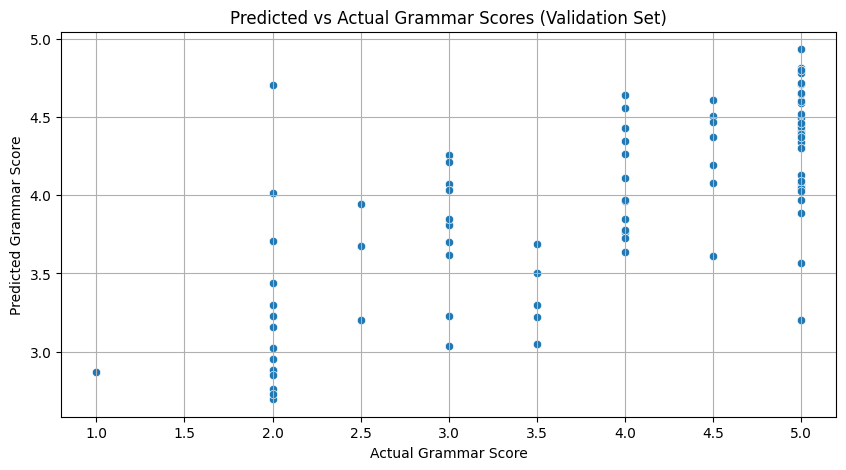

In [16]:
# ========== 10. VISUALIZATION ==========
plt.figure(figsize=(10, 5))
sns.scatterplot(x=y_val, y=y_pred_val)
plt.xlabel("Actual Grammar Score")
plt.ylabel("Predicted Grammar Score")
plt.title("Predicted vs Actual Grammar Scores (Validation Set)")
plt.grid()
plt.show()


In [ ]:
## 📘 Summary

- **Approach**: MFCC-based feature extraction + RandomForest Regressor.
- **Training RMSE**: `0.3223`
- **Validation Pearson Correlation**: `0.8412`
- **Feature Count**: 40 (20 MFCC mean + 20 MFCC std)
- **Next Steps**: Try Wav2Vec2 embeddings, larger models, or sequence models (LSTM/CNN).

Validation Pearson Correlation: 0.7310
